## CP Atmospheric River Detection Testing

In [1]:
import xarray as xr
import numpy as np

# these imports will be module-level eventually
from scipy.ndimage import labeled_comprehension
from skimage.measure import regionprops

#import hvplot.xarray
#import hvplot.pandas

from config import ar_params, ard_fp, spatial_resolution_reprojected
from ar_detection import compute_intensity_mask, label_contiguous_mask_regions
from ar_detection import filter_regions_by_geometry, filter_regions_by_ivt_direction_coherence, filter_regions_by_ivt_poleward_strength

# import dask
# import dask.distributed as dd
# from dask import delayed
# client = dd.Client()
# Disable the spill-to-disk behavior?
# dask.config.set({"temporary_directory": "/atlas_scratch/cparr4/atmospheric_rivers/"})

In [2]:
# we know this is a haines atmospheric river event
test_case = "2020-12-01T12:00:00"

In [3]:
ar_params

{'window': 75,
 'ivt_percentile': 85,
 'ivt_floor': 100,
 'direction_deviation_threshold': 45,
 'mean_meridional': 50,
 'orientation_deviation_threshold': 45,
 'min_axis_length': 2000}

In [4]:
ds = xr.open_dataset(ard_fp)
ds.rio.write_crs("epsg:4326", inplace=True)
ds
# chunk options to avoid memory allocation errors
# ds = ds.chunk({"time": "auto"})
# ds = ds.chunk({"time": "auto", "latitude": "auto", "longitude": "auto"})
# ds = ds.chunk({"latitude": 1, "longitude": 1})

<xarray.Dataset>
Dimensions:       (time: 4384, latitude: 141, longitude: 141)
Coordinates:
  * time          (time) datetime64[ns] 2019-01-01 ... 2021-12-31T18:00:00
  * longitude     (longitude) float32 -170.0 -169.8 -169.5 ... -135.2 -135.0
  * latitude      (latitude) float32 65.0 64.75 64.5 64.25 ... 30.5 30.25 30.0
    spatial_ref   int64 0
Data variables:
    p72.162       (time, latitude, longitude) float32 ...
    ivt_mag       (time, latitude, longitude) float32 ...
    ivt_dir       (time, latitude, longitude) float32 ...
    ivt_quantile  (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-28 22:05:12 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

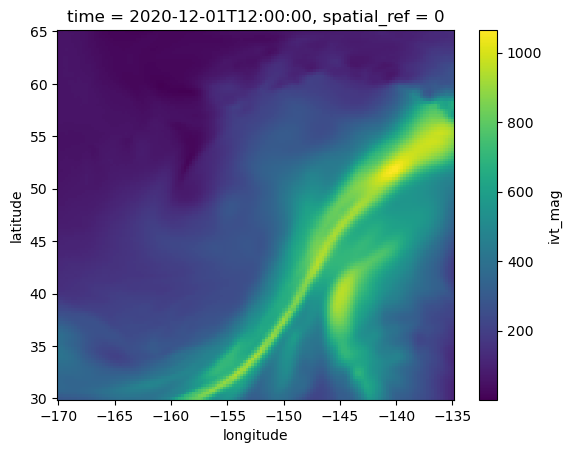

In [5]:
ds["ivt_mag"].sel(time=test_case).plot()

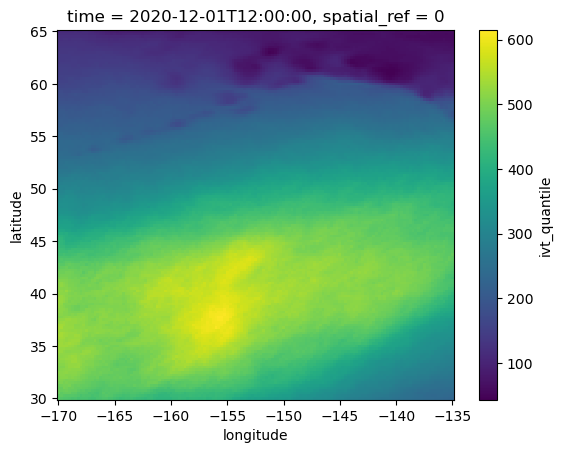

In [6]:
ds["ivt_quantile"].sel(time=test_case).plot()

In [7]:
%%time
ds["thresholded"] = compute_intensity_mask(ds["ivt_mag"], ds["ivt_quantile"], ar_params["ivt_floor"])

CPU times: user 669 ms, sys: 590 ms, total: 1.26 s
Wall time: 1.26 s


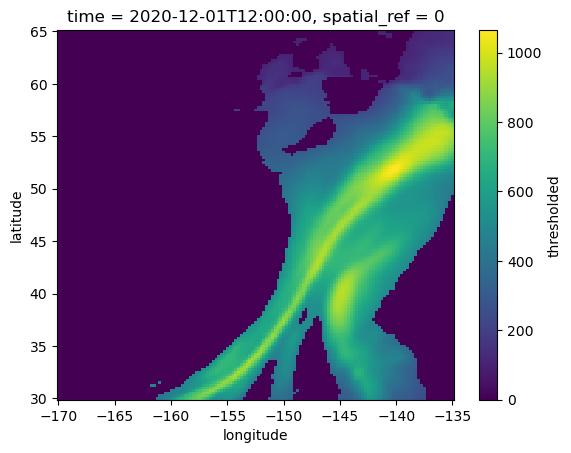

In [8]:
ds["thresholded"].sel(time=test_case).plot()

In [9]:
%%time
labeled_regions = label_contiguous_mask_regions(ds["thresholded"])

CPU times: user 5.5 s, sys: 220 ms, total: 5.72 s
Wall time: 5.72 s


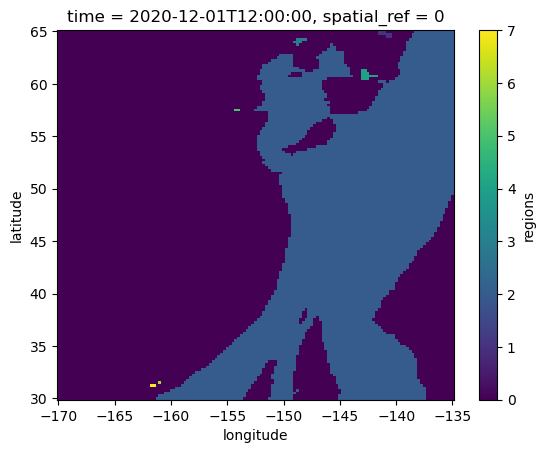

In [10]:
labeled_regions.sel(time=test_case).plot()

In [ ]:
# we should add an extra function to regionprops
# this function should get the lat and lon of the indices
# and compute the haversine distance between them
# this value should then be compared to min-axis-length


In [22]:
labeled_regions.sel(time=test_case).astype(int).latitude

<xarray.DataArray 'latitude' (latitude: 141)>
array([65.  , 64.75, 64.5 , 64.25, 64.  , 63.75, 63.5 , 63.25, 63.  , 62.75,
       62.5 , 62.25, 62.  , 61.75, 61.5 , 61.25, 61.  , 60.75, 60.5 , 60.25,
       60.  , 59.75, 59.5 , 59.25, 59.  , 58.75, 58.5 , 58.25, 58.  , 57.75,
       57.5 , 57.25, 57.  , 56.75, 56.5 , 56.25, 56.  , 55.75, 55.5 , 55.25,
       55.  , 54.75, 54.5 , 54.25, 54.  , 53.75, 53.5 , 53.25, 53.  , 52.75,
       52.5 , 52.25, 52.  , 51.75, 51.5 , 51.25, 51.  , 50.75, 50.5 , 50.25,
       50.  , 49.75, 49.5 , 49.25, 49.  , 48.75, 48.5 , 48.25, 48.  , 47.75,
       47.5 , 47.25, 47.  , 46.75, 46.5 , 46.25, 46.  , 45.75, 45.5 , 45.25,
       45.  , 44.75, 44.5 , 44.25, 44.  , 43.75, 43.5 , 43.25, 43.  , 42.75,
       42.5 , 42.25, 42.  , 41.75, 41.5 , 41.25, 41.  , 40.75, 40.5 , 40.25,
       40.  , 39.75, 39.5 , 39.25, 39.  , 38.75, 38.5 , 38.25, 38.  , 37.75,
       37.5 , 37.25, 37.  , 36.75, 36.5 , 36.25, 36.  , 35.75, 35.5 , 35.25,
       35.  , 34.75, 34.5 , 34.25, 34.  , 33.75, 33.5 , 33.25, 33.  , 32.75,
       32.5 , 32.25, 32.  , 31.75, 31.5 , 31.25, 31.  , 30.75, 30.5 , 30.25,
       30.  ], dtype=float32)
Coordinates:
    time         datetime64[ns] 2020-12-01T12:00:00
  * latitude     (latitude) float32 65.0 64.75 64.5 64.25 ... 30.5 30.25 30.0
    spatial_ref  int64 0

In [20]:
regionprops(labeled_regions.sel(time=test_case).astype(int))[0].area

<xarray.DataArray 'regions' ()>
array(10.)
Coordinates:
    time         datetime64[ns] 2020-12-01T12:00:00
    spatial_ref  int64 0

In [ ]:
%%time
# labeled_regions is modified in place!
drop_by_shape = filter_regions_by_geometry(labeled_regions, ar_params["min_axis_length"])

In [ ]:
# verify some AR candidates were filtered out
# CP note: would be good to log this
len(drop_by_shape.keys())

In [ ]:
labeled_regions.sel(time=test_case).plot()

In [ ]:
%%time
# labeled_regions is modified in place again!
drop_by_coherence = filter_regions_by_ivt_direction_coherence(labeled_regions, ds["ivt_dir"])

In [ ]:
# verify some AR candidates were filtered out
# CP note: would be good to log this
len(drop_by_coherence.keys())

In [ ]:
labeled_regions.sel(time=test_case).plot()

In [ ]:
%%time
# again, labeled_regions is modified in place!
drop_by_poleward = filter_regions_by_ivt_poleward_strength(labeled_regions, ds["p72.162"])

In [ ]:
# verify some AR candidates were filtered out
# CP note: would be good to log this
len(drop_by_poleward.keys())

In [ ]:
labeled_regions.sel(time=test_case).plot()

In [ ]:
labeled_regions.coords

In [ ]:
nonzero_slices = labeled_regions.where(labeled_regions != 0, drop=True).time

In [ ]:
labeled_regions.sel(time="2021-12-31T18:00:00").plot()

In [ ]:
ds["ivt_mag"].sel(time="2021-12-31T18:00:00").plot()

In [ ]:
nonzero_slices

In [ ]:
2019 / 4

In [ ]:
dev_copy = labeled_regions.copy()

In [ ]:
dev_copy.sel(time=test_case)

In [ ]:
x = regionprops(dev_copy.sel(time=test_case).astype(int).values)


In [ ]:
x[0].orientation

In [ ]:
np.rad2deg(x[0].orientation)

In [ ]:
def convert_to_southerly_azimuth(orientation):
    """Convert a region's orientation value to an azimuth angle for comparison with IVT direction values"""
    # force westerly for horizontal orientation
    if orientation == -90 or orientation == 90:
        azimuth = 270
    # force southerly for vertical orientation
    elif orientation == 0:
        azimuth = 180
    # force NW quadrant values to southeasterly, NE quadrant values to southwesterly
    elif orientation < 0:
        azimuth = np.abs(orientation) + 180
    elif orientation > 0:
        azimuth = 180 - orientation
    return azimuth

In [ ]:
convert_to_southerly_azimuth(np.rad2deg(x[0].orientation))

In [ ]:
dev_ivt_dir = ds["ivt_dir"].sel(time=test_case)
dev_ivt_dir.rio.write_crs("epsg:4326", inplace=True)
devivt_direction_3338 = dev_ivt_dir.rio.reproject("epsg:3338",
                                                  resolution=spatial_resolution_reprojected,
                                                  resampling=rasterio.enums.Resampling.nearest)



In [ ]:
import matplotlib.pyplot as plt

In [ ]:
dev_copy.sel(time=test_case).data > 0

In [ ]:
plt.imshow(devivt_direction_3338.data * (dev_copy.sel(time=test_case).data > 0))
plt.colorbar()

In [ ]:
j = devivt_direction_3338.data * (dev_copy.sel(time=test_case).data > 0)
j[j==0] = np.nan

In [ ]:
np.nanmean(j)

In [ ]:
243-182

In [ ]:
test_arr = (dev_copy.sel(time=test_case).data > 0) * 1
plt.imshow(test_arr)

In [ ]:
def find_furthest_points(array):
    # Find the indices of the 1 values in the array
    indices = np.argwhere(array == 1)
    
    # Compute all pairwise distances
    distances = np.linalg.norm(indices[:, None] - indices, axis=2)
    
    # Find the maximum distance and its corresponding indices
    max_distance_index = np.unravel_index(distances.argmax(), distances.shape)
    point1_index = indices[max_distance_index[0]]
    point2_index = indices[max_distance_index[1]]
    furthest_distance = distances[max_distance_index]
    
    # Compute the angle between the two points
    angle = np.degrees(np.arctan2(point2_index[0] - point1_index[0], point2_index[1] - point1_index[1]))
    #cardinal_angle = (90 - angle) % 360  # Convert to cardinal direction degrees
    return (point1_index, point2_index), furthest_distance, angle

In [ ]:
import numpy as np

def haversine_distance(point1, point2):
    """
    Compute the great circle distance between two points on the Earth's surface using the Haversine formula.
    The input points should be in (latitude, longitude) format in degrees.
    """
    # Convert latitude and longitude to radians
    lat1, lon1 = np.radians(point1)
    lat2, lon2 = np.radians(point2)
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    # Earth's radius in kilometers
    radius = 6371
    
    # Compute the great circle distance
    distance = radius * c
    
    return distance

def find_furthest_points(array, coordinates):
    # Find the indices of the 1 values in the array
    indices = np.argwhere(array == 1)
    
    # Convert indices to corresponding coordinates
    points = coordinates[indices[:, 0], indices[:, 1]]
    
    # Compute all pairwise distances using Haversine formula
    distances = haversine_distance(points[:, None], points)
    
    # Find the maximum distance and its corresponding indices
    max_distance_index = np.unravel_index(distances.argmax(), distances.shape)
    point1_index = indices[max_distance_index[0]]
    point2_index = indices[max_distance_index[1]]
    furthest_distance = distances[max_distance_index]
    
    return (point1_index, point2_index), furthest_distance


In [ ]:
wgs = dev_copy.sel(time=test_case).rio.reproject("epsg:4326",
                                                  resampling=rasterio.enums.Resampling.nearest)
wgs

In [ ]:
ds

In [ ]:
ds.rio.crs.to_dict()

In [ ]:
find_furthest_points(test_arr)

In [ ]:
# this function should compute a distance matrix masked by the labeld_region array
# then find the points of maximum distance
# and measure the bearing along a line intersecting these two points
# that would then be the direction of elongation


In [ ]:
# 3. Consistency Between Object Mean IVT Direction and Overall Orientation.
# I think we would find the two cells within the labeled region that are at maximum distance from each other,
# find the line between them, and get its azimuth to compare to the mean direction calculated in step
# NOTE that the degree directions used in step 1 represent direction the AR is coming FROM.
# we should be able to use regionprops `orientation` here.
# create  a test case though to make sure circular coordinates are handled and to verify to/from directionality.


def convert_to_southerly_azimuth(orientation):
    """Convert a region's orientation value to an azimuth angle for comparison with IVT direction values"""
    # force westerly for horizontal orientation
    if orientation == -90 or orientation == 90:
        azimuth = 270
    # force southerly for vertical orientation
    elif orientation == 0:
        azimuth = 180
    # force NW quadrant values to southeasterly, NE quadrant values to southwesterly
    elif orientation < 0:
        azimuth = np.abs(orientation) + 180
    elif orientation > 0:
        azimuth = 180 - orientation
    return azimuth


def filter_regions_by_orientation_consistency(regions, ivt_direction,
                                              deviation_threshold=ar_params["orientation_deviation_threshold"]):
    """
    Parameters
    ----------
    regions : xarray.DataArray
        labeled regions of contiguous IVT quantile and floor exceedance with time, lat, and lon coordinates
    min_axis_length : int
        units in km

    Returns
    -------
    drop_dict
        dict of regions failing to meet AR shape criteria where keys are timesteps
        and values are the labeled regions of the time slice that fail to meet the criteria.
        the output dictionary is just a reference for confirming that the non-AR labels are dropped.
    """

    drop_dict = {}

    # prescribe CRS
    ivt_direction.rio.write_crs("epsg:4326", inplace=True)
    # reproject to 3338 with prescribed grid cell size to match xy dimensions of labeled data
    ivt_direction_3338 = ivt_direction.rio.reproject("epsg:3338", resolution=spatial_resolution_reprojected, resampling=rasterio.enums.Resampling.nearest)
                                                  
    for labeled_time_slice, ivt_direction_slice in zip(regions, ivt_direction_3338.data):
        
        measured_regions = regionprops(labeled_time_slice.astype(int).values, intensity_image=ivt_direction_slice)

        drop_list = []
        
        for binary_blob in measured_regions:
            azimuth = convert_to_southerly_azimuth(round(np.rad2deg(binary_blob.orientation)))
            mean_ivt_direction_within_blob = round(binary_blob.intensity_mean)
            print(labeled_time_slice.time.values, azimuth, mean_ivt_direction_within_blob)
    #         degrees_deviation = abs((azimuth - mean_ivt_direction_within_blob + 180) % 360 - 180)
    #         if degrees_deviation > deviation_threshold:
    #             drop_list.append(binary_blob.label)
        
    #     if len(drop_list) > 0:
    #         drop_dict[labeled_time_slice.time.values] = drop_list
    
    # # use the drop dictionary to do another loop thru the original dataset and reassign dropped labels to 0
    # for d in drop_dict:
    #     regions.loc[dict(time=d)] = xr.where(regions.sel(time=d).isin(drop_dict[d]), 0, regions.sel(time=d))
         
    # return drop_dict


# def is_orientation_consistent_with_ivt_direction():
#     """
#     Angle between the 0th axis (rows) and the major axis of the ellipse that has the same second moments as the region,
#     ranging from -pi/2 to pi/2 counter-clockwise (-90 degrees to 90 degrees).

#     """
#     pass

    
# def filter_regions_by_orientation():
#     """Filter by consistency of IVT direction with object orientation. Objects where the mean IVT direction deviates
#     from the objection orientation by more than 45 degrees will be discarded.
#     Note that Guan and Waliser (2015) prescribe orientation as being the the azimuth of the line drawn
#     at maximum great circle distance of the labeled region. Azimuth must indicate the "from" direction.
#     Note that this filter should eventually be combined with another filter because both are computing region properties.
#     """

#     pass

In [ ]:
filter_regions_by_orientation_consistency(labeled_regions, ds["ivt_dir"])

In [ ]:
len(drop_by_orientation)

In [ ]:
from skimage.filters import threshold_multiotsu
import matplotlib
import numpy as np
# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()


In [ ]:
from skimage.segmentation import chan_vese

image = haines_ivt_mag.data
# Feel free to play around with the parameters to see how they impact the result
cv = chan_vese(image, mu=0.5, lambda1=1, lambda2=1, tol=1e-3,
               max_num_iter=200, dt=0.5, init_level_set="checkerboard",
               extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = f'Chan-Vese segmentation - {len(cv[2])} iterations'
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

This is a lot like the snowdrift-finding problem - where is the concentration of water? Edges are fuzzy, and there is a consistent shape, but many variations within that shape, and shapes evolve over time. 

### plotting

Check out IVT magnitude, IVT percentile, and labeled AR regions in two interactive viewers. The Haines AR event was on Dec 1 and 2, 2020.

In [ ]:
ds['ivt_mag'].hvplot(groupby='time', x = 'longitude', y = 'latitude', width=600, widget_type='scrubber', widget_location='right', clim=(0, 800))

In [ ]:
ds['regions'].hvplot(groupby='time', x = 'longitude', y = 'latitude', width=600, widget_type='scrubber', widget_location='right', clim=(0, 4))